### Libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from utils import *

In [4]:
print("Pytorch version: ... {} ".format(torch.__version__))

Pytorch version: ... 2.0.0+cu117 


In [11]:
## Conversion from PyTorch 3D GitHub repository

def _angle_from_tan(
    axis: str, other_axis: str, data, horizontal: bool, tait_bryan: bool
) -> torch.Tensor:
    """
    Extract the first or third Euler angle from the two members of
    the matrix which are positive constant times its sine and cosine.

    Args:
        axis: Axis label "X" or "Y or "Z" for the angle we are finding.
        other_axis: Axis label "X" or "Y or "Z" for the middle axis in the
            convention.
        data: Rotation matrices as tensor of shape (..., 3, 3).
        horizontal: Whether we are looking for the angle for the third axis,
            which means the relevant entries are in the same row of the
            rotation matrix. If not, they are in the same column.
        tait_bryan: Whether the first and third axes in the convention differ.

    Returns:
        Euler Angles in radians for each matrix in data as a tensor
        of shape (...).
    """

    i1, i2 = {"X": (2, 1), "Y": (0, 2), "Z": (1, 0)}[axis]
    if horizontal:
        i2, i1 = i1, i2
    even = (axis + other_axis) in ["XY", "YZ", "ZX"]
    if horizontal == even:
        return torch.atan2(data[..., i1], data[..., i2])
    if tait_bryan:
        return torch.atan2(-data[..., i2], data[..., i1])
    return torch.atan2(data[..., i2], -data[..., i1])

def _index_from_letter(letter: str) -> int:
    if letter == "X":
        return 0
    if letter == "Y":
        return 1
    if letter == "Z":
        return 2
    raise ValueError("letter must be either X, Y or Z.")

def matrix_to_euler_angles(matrix: torch.Tensor, convention: str) -> torch.Tensor:
    """
    Convert rotations given as rotation matrices to Euler angles in radians.

    Args:
        matrix: Rotation matrices as tensor of shape (..., 3, 3).
        convention: Convention string of three uppercase letters.

    Returns:
        Euler angles in radians as tensor of shape (..., 3).
    """
    if len(convention) != 3:
        raise ValueError("Convention must have 3 letters.")
    if convention[1] in (convention[0], convention[2]):
        raise ValueError(f"Invalid convention {convention}.")
    for letter in convention:
        if letter not in ("X", "Y", "Z"):
            raise ValueError(f"Invalid letter {letter} in convention string.")
    if matrix.size(-1) != 3 or matrix.size(-2) != 3:
        raise ValueError(f"Invalid rotation matrix shape {matrix.shape}.")
    i0 = _index_from_letter(convention[0])
    i2 = _index_from_letter(convention[2])
    tait_bryan = i0 != i2
    if tait_bryan:
        central_angle = torch.asin(
            matrix[..., i0, i2] * (-1.0 if i0 - i2 in [-1, 2] else 1.0)
        )
    else:
        central_angle = torch.acos(matrix[..., i0, i0])

    o = (
        _angle_from_tan(
            convention[0], convention[1], matrix[..., i2], False, tait_bryan
        ),
        central_angle,
        _angle_from_tan(
            convention[2], convention[1], matrix[..., i0, :], True, tait_bryan
        ),
    )
    return torch.stack(o, -1)


### Generate 2DoF Dataset

In [3]:
# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
robot_choice = "2DoF-2R"
"""
q_lim = torch.tensor([[-torch.pi, torch.pi],
                      [-torch.pi, torch.pi],
                      [-torch.pi, torch.pi]])
"""

q_lim = torch.tensor([[0, torch.pi],
                      [0, torch.pi]])

# generate dataset with a specified number of samples
n_samples = 10000
data_position = []
for _ in range(n_samples):
    t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
    DH = get_DH(robot_choice, t)
    T = forward_kinematics(DH)
    if robot_choice == "2DoF-2R":
        # x,y,t1,t2,t3 where x,y (m) and t (rad)
        data_position.append(torch.cat([T[:2,-1], t]).numpy())
      
data_position_a = np.array(data_position)


# save dataset
if robot_choice == "2DoF-2R":
    header = ["x","y","t1","t2"]
    
df = pd.DataFrame(data_position_a)
df.to_csv("data_"+robot_choice+".csv",
          index=False,
          header=header)

### Visualize 2DoF Dataset

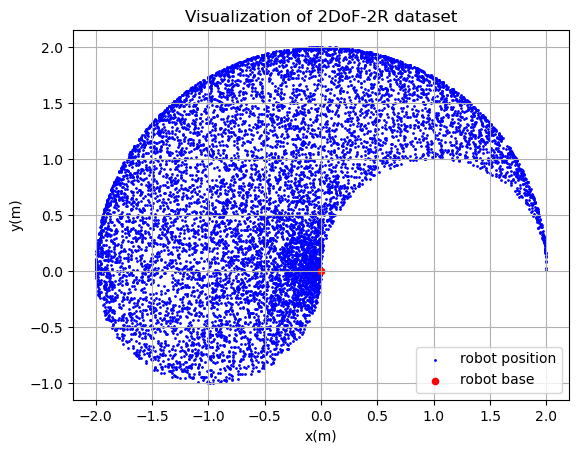

In [4]:
fig, ax = plt.subplots()
ax.scatter(data_position_a[:,0], data_position_a[:,1],s=1, marker='o', c='b')
ax.scatter(0,0,s=20, marker='o', c='r')
ax.set(xlabel='x(m)', ylabel='y(m)',
       title='Visualization of '+robot_choice+ ' dataset')
ax.legend(["robot position","robot base"])
ax.grid()

In [ ]:
### Make it a classification

### Generate 3DoF Dataset

In [3]:
# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
robot_choice = "3DoF-3R-2"
"""
q_lim = torch.tensor([[-torch.pi, torch.pi],
                      [-torch.pi, torch.pi],
                      [-torch.pi, torch.pi]])
"""

q_lim = torch.tensor([[0, torch.pi],
                      [0, torch.pi],
                      [0, torch.pi]])

# generate dataset with a specified number of samples
n_samples = 10000
data_position = []
for _ in range(n_samples):
    t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
    DH = get_DH(robot_choice, t)
    T = forward_kinematics(DH)
    if robot_choice == "3DoF-3R-2":
        # x,y,t1,t2,t3 where x,y (m) and t (rad)
        data_position.append(torch.cat([T[:2,-1], t]).numpy())
      
data_position_a = np.array(data_position)


# save dataset
if robot_choice == "3DoF-3R-2":
    header = ["x","y","t1","t2","t3"]
    
df = pd.DataFrame(data_position_a)
df.to_csv("data_"+robot_choice+".csv",
          index=False,
          header=header)

### Visualize 3DoF Dataset

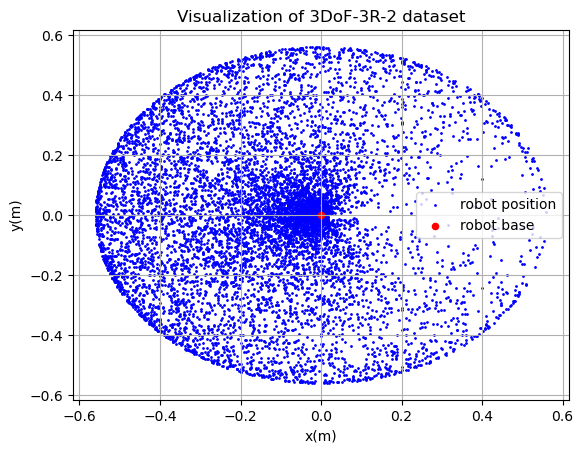

In [4]:
fig, ax = plt.subplots()
ax.scatter(data_position_a[:,0], data_position_a[:,1],s=1, marker='o', c='b')
ax.scatter(0,0,s=20, marker='o', c='r')
ax.set(xlabel='x(m)', ylabel='y(m)',
       title='Visualization of '+robot_choice+ ' dataset')
ax.legend(["robot position","robot base"])
ax.grid()

### Generate 4DoF Dataset

In [30]:
# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
robot_choice = "4DoF-2RPR"
"""
q_lim = torch.tensor([[0, torch.deg2rad(torch.tensor(180))],
                      [torch.deg2rad(torch.tensor(0)), torch.deg2rad(torch.tensor(180))],
                      [torch.tensor(0.01), torch.tensor(0.25)],
                      [torch.deg2rad(torch.tensor(30)), torch.deg2rad(torch.tensor(60))]])
"""

q_lim = torch.tensor([[0, torch.deg2rad(torch.tensor(360))],
                      [torch.deg2rad(torch.tensor(0)), torch.deg2rad(torch.tensor(360))],
                      [torch.tensor(0.01), torch.tensor(0.5)],
                      [torch.deg2rad(torch.tensor(0)), torch.deg2rad(torch.tensor(360))]])

# generate dataset with a specified number of samples
n_samples = 100000
data_position = []
for _ in range(n_samples):
    t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
    DH = get_DH(robot_choice, t)
    T = forward_kinematics(DH)
    if robot_choice == "4DoF-2RPR":
        # x,y,t1,t2,t3 where x,y (m) and t (rad)
        data_position.append(torch.cat([T[:3,-1], t]).numpy())
      
data_position_a = np.array(data_position)


# save dataset
if robot_choice == "4DoF-2RPR":
    header = ["x","y","z","t1","t2","t3","t4"]
    
df = pd.DataFrame(data_position_a)
df.to_csv("data_"+robot_choice+"_"+str(n_samples)+"_2.csv",
          index=False,
          header=header)

data_position_a = data_position_a * 1000

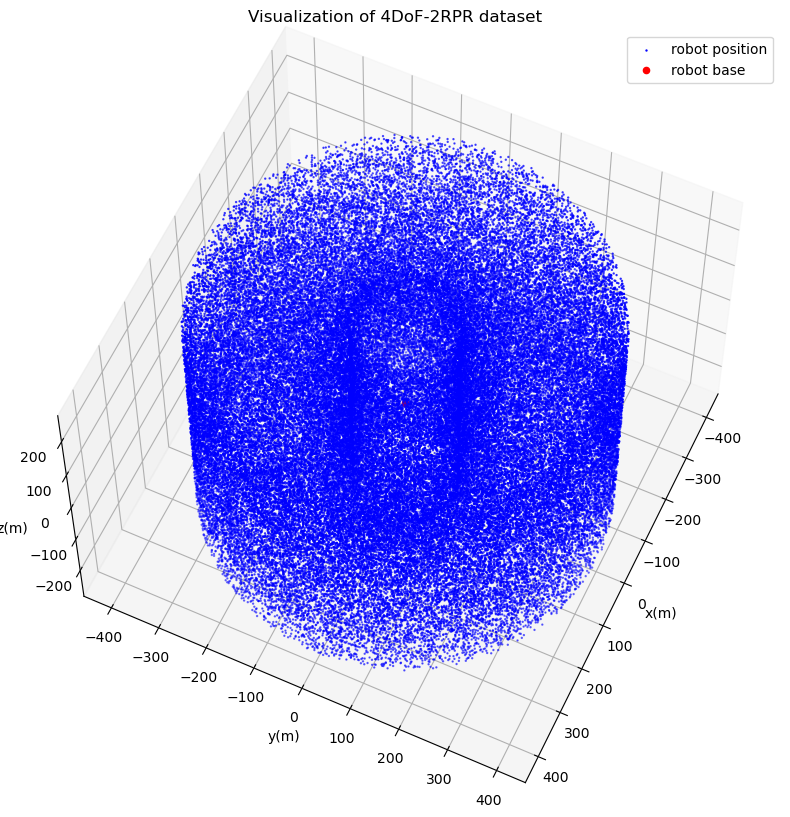

In [31]:
### Visualize 4DoF Dataset
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(data_position_a[:,0], data_position_a[:,1], data_position_a[:,2], s=2, c='b', marker='.')
ax.scatter(0,0,0,s=20, marker='o', c='r')
ax.legend(["robot position","robot base"])
ax.set(xlabel='x(m)', ylabel='y(m)', zlabel='z(m)',
       title='Visualization of '+robot_choice+ ' dataset')
ax.view_init(60, 25)
plt.show()

### Generate 7DoF Dataset

In [12]:
# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
robot_choice = "6DoF-6R-Puma260"
"""
q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(110))],
                      [torch.deg2rad(torch.tensor(-75)), torch.deg2rad(torch.tensor(240))],
                      [torch.deg2rad(torch.tensor(-235)), torch.deg2rad(torch.tensor(60))],
                      [torch.deg2rad(torch.tensor(-580)), torch.deg2rad(torch.tensor(40))],
                      [torch.deg2rad(torch.tensor(-30)), torch.deg2rad(torch.tensor(200))],
                      [torch.deg2rad(torch.tensor(-215)), torch.deg2rad(torch.tensor(295))]])
"""

q_lim = torch.tensor([[torch.deg2rad(torch.tensor(-180)), torch.deg2rad(torch.tensor(110))],
                      [torch.deg2rad(torch.tensor(-75)), torch.deg2rad(torch.tensor(240))],
                      [torch.deg2rad(torch.tensor(-235)), torch.deg2rad(torch.tensor(60))],
                      [torch.deg2rad(torch.tensor(-580)), torch.deg2rad(torch.tensor(40))],
                      [torch.deg2rad(torch.tensor(-30)), torch.deg2rad(torch.tensor(200))],
                      [torch.deg2rad(torch.tensor(-215)), torch.deg2rad(torch.tensor(295))]])

# generate dataset with a specified number of samples
n_samples = 100000
print_steps = 10
data_position = []
for s in range(n_samples):
    t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
    #print(t)
    DH = get_DH(robot_choice, t)
    #print(DH) 
    T = forward_kinematics(DH)
    R = T[:3,:3]       
    #print(T)
    rpy = matrix_to_euler_angles(R, "XYZ")
    #print(rpy)
    #print()

    #sys.exit()

    if s%(n_samples/print_steps) == 0:
        print("Generated [{}] samples ...".format(s))
    
    if robot_choice == "6DoF-6R-Puma260":
        # x,y,z,R,P,Y,t1,t2,t3,t4,t5,t6 where x,y,z (m) and t (rad)
        data_position.append(torch.cat([T[:3,-1], rpy, t]).numpy())
      
data_position_a = np.array(data_position)


# save dataset
if robot_choice == "6DoF-6R-Puma260":
    header = ["x", "y", "z","R","P","Y","t1", "t2", "t3", "t4", "t5", "t6"]
    
df = pd.DataFrame(data_position_a)
df.to_csv("data_"+robot_choice+"_"+str(n_samples)+".csv",
          index=False,
          header=header)

data_position_a = data_position_a * 1000

print("Data generation done!")

Generated [0] samples ...
Generated [10000] samples ...
Generated [20000] samples ...
Generated [30000] samples ...
Generated [40000] samples ...
Generated [50000] samples ...
Generated [60000] samples ...
Generated [70000] samples ...
Generated [80000] samples ...
Generated [90000] samples ...
Data generation done!


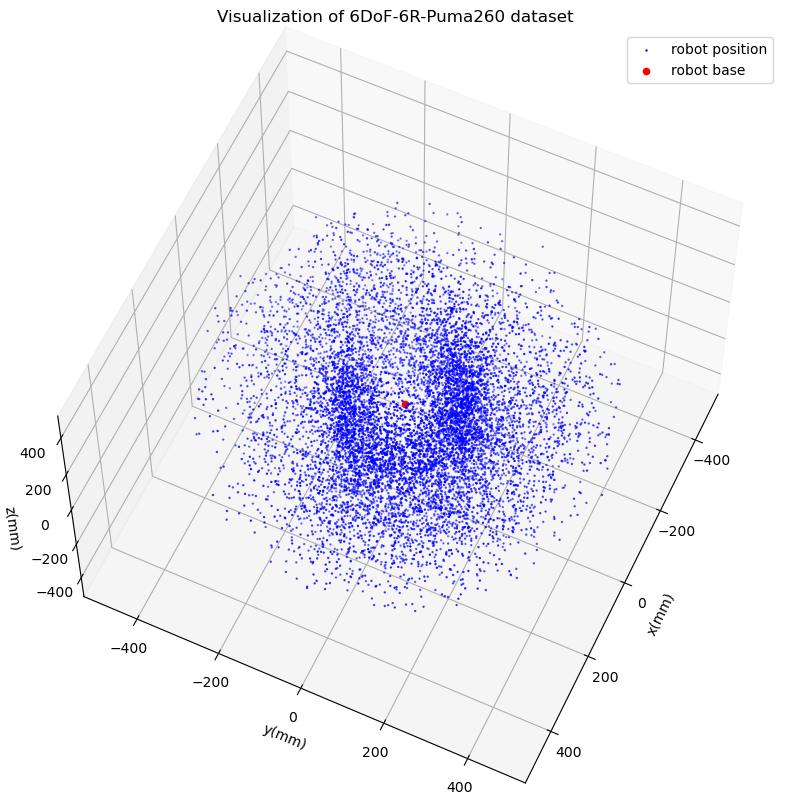

In [5]:
### Visualize 4DoF Dataset
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(data_position_a[:,0], data_position_a[:,1], data_position_a[:,2], s=2, c='b', marker='.')
ax.scatter(0,0,0,s=20, marker='o', c='r')
ax.legend(["robot position","robot base"])
ax.set(xlabel='x(mm)', ylabel='y(mm)', zlabel='z(mm)',
       title='Visualization of '+robot_choice+ ' dataset')
ax.view_init(60, 25)
plt.show()

In [24]:
import numpy
import torch 

x = torch.rand(100,3)
mapping_size = 32
B_dict = {}
B_dict['basic'] = torch.eye(mapping_size,3)
B = B_dict['basic']

In [25]:
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = torch.matmul((2*torch.pi*x), B.T)
        print(x.shape)
        print(B.shape)
        print(x_proj.shape)
        print(torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1).shape)
    
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

xB = input_mapping(x,B)

torch.Size([100, 3])
torch.Size([32, 3])
torch.Size([100, 32])
torch.Size([100, 64])


### Classification

In [ ]:
# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
robot_choice = "2DoF-2R"
"""
q_lim = torch.tensor([[-torch.pi, torch.pi],
                      [-torch.pi, torch.pi]])
"""

q_lim = torch.tensor([[0, torch.pi],
                      [0, torch.pi]])

# generate dataset with a specified number of samples
n_samples = 10000
data_position = []
for _ in range(n_samples):
    t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
    DH = get_DH(robot_choice, t)
    T = forward_kinematics(DH)
    if robot_choice == "2DoF-2R":
        # x,y,t1,t2,t3 where x,y (m) and t (rad)
        data_position.append(torch.cat([T[:2,-1], t]).numpy())
      
data_position_a = np.array(data_position)


# save dataset
if robot_choice == "2DoF-2R":
    header = ["x","y","t1","t2"]
    
df = pd.DataFrame(data_position_a)
df.to_csv("data_"+robot_choice+".csv",
          index=False,
          header=header)

# Torch Training

Generation = 1
Fitness    = -1.571385383605957
Generation = 2
Fitness    = -1.571385383605957
Generation = 3
Fitness    = -1.571385383605957
Generation = 4
Fitness    = -1.571385383605957
Generation = 5
Fitness    = -1.5699213743209839
Generation = 6
Fitness    = -1.5699213743209839
Generation = 7
Fitness    = -1.568060278892517
Generation = 8
Fitness    = -1.568060278892517
Generation = 9
Fitness    = -1.5413222312927246
Generation = 10
Fitness    = -1.5413222312927246
Generation = 11
Fitness    = -1.5413222312927246
Generation = 12
Fitness    = -1.5413222312927246
Generation = 13
Fitness    = -1.5413222312927246
Generation = 14
Fitness    = -1.5220046043395996
Generation = 15
Fitness    = -1.5220046043395996
Generation = 16
Fitness    = -1.5220046043395996
Generation = 17
Fitness    = -1.5220046043395996
Generation = 18
Fitness    = -1.5220046043395996
Generation = 19
Fitness    = -1.5220046043395996
Generation = 20
Fitness    = -1.5073089599609375
Generation = 21
Fitness    = -1.507

Fitness    = -1.4848392009735107
Generation = 168
Fitness    = -1.4848392009735107
Generation = 169
Fitness    = -1.4848392009735107
Generation = 170
Fitness    = -1.4848392009735107
Generation = 171
Fitness    = -1.4848392009735107
Generation = 172
Fitness    = -1.4848392009735107
Generation = 173
Fitness    = -1.4848392009735107
Generation = 174
Fitness    = -1.4848392009735107
Generation = 175
Fitness    = -1.4848392009735107
Generation = 176
Fitness    = -1.4848392009735107
Generation = 177
Fitness    = -1.4848392009735107
Generation = 178
Fitness    = -1.4848392009735107
Generation = 179
Fitness    = -1.4848392009735107
Generation = 180
Fitness    = -1.4848392009735107
Generation = 181
Fitness    = -1.4848392009735107
Generation = 182
Fitness    = -1.4848392009735107
Generation = 183
Fitness    = -1.4848392009735107
Generation = 184
Fitness    = -1.4848392009735107
Generation = 185
Fitness    = -1.4848392009735107
Generation = 186
Fitness    = -1.4848392009735107
Generation = 187


Fitness    = -1.4848392009735107


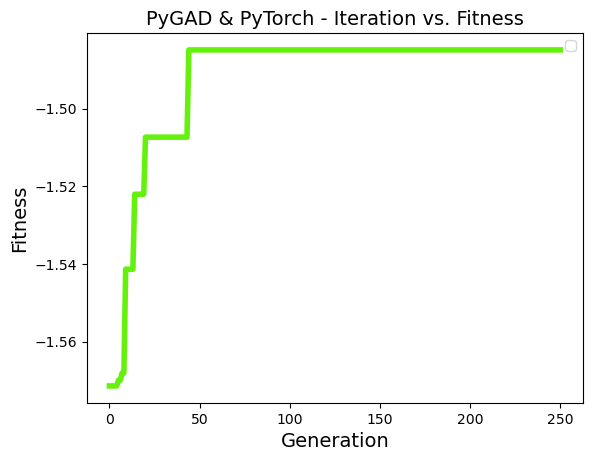

Fitness value of the best solution = -1.4848392009735107
Index of the best solution : 0
Predictions : 
 [[ 0.40376478  0.3074476  -0.3446847 ]
 [-1.4118807  -0.31802815  0.06877175]
 [ 0.40376478  0.3074476  -0.3446847 ]
 ...
 [-1.1391232  -0.45469552 -0.05581024]
 [ 0.40376478  0.3074476  -0.3446847 ]
 [ 0.40376478  0.3074476  -0.3446847 ]]
Absolute Error :  1.4848392


In [14]:
import torch
# import torchga
import pygad.torchga as torchga

def fitness_func(ga_instance, solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)

    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    predictions = model(data_inputs)
#     abs_error = loss_function(predictions, data_outputs).detach().numpy() + 0.00000001
    abs_error = loss_function(predictions, data_outputs).detach().numpy()

#     solution_fitness = 1.0 / abs_error
    solution_fitness = -abs_error

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

# Create the PyTorch model.
input_layer = torch.nn.Linear(2, 5)
relu_layer = torch.nn.ReLU()
sigmoid_layer = torch.nn.Sigmoid()
h1 = torch.nn.Linear(5, 128)
h2 = torch.nn.Linear(128, 512)
h3 = torch.nn.Linear(512, 128)
h4 = torch.nn.Linear(128, 5)
output_layer = torch.nn.Linear(5, 3)

model = torch.nn.Sequential(input_layer,
                            sigmoid_layer,
                            h1,
                            sigmoid_layer,
                            h2,
                            sigmoid_layer,
                            h3,
                            sigmoid_layer,
                            h4,
                            relu_layer,
                            output_layer)
# print(model)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=10)

loss_function = torch.nn.L1Loss()

# Data inputs


training_data = data_position_a[:8000, :2]
testing_data = data_position_a[8000:, :2]

training_targets = data_position_a[:8000, 2:]
testing_targets = data_position_a[8000:, 2:]

data_inputs = torch.from_numpy(training_data)
data_outputs = torch.from_numpy(training_targets)

# data_inputs = torch.tensor([[0.02, 0.1, 0.15],
#                             [0.7, 0.6, 0.8],
#                             [1.5, 1.2, 1.7],
#                             [3.2, 2.9, 3.1]])

# # Data outputs
# data_outputs = torch.tensor([[0.1],
#                              [0.6],
#                              [1.3],
#                              [2.5]])

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
num_generations = 250 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(data_inputs)
print("Predictions : \n", predictions.detach().numpy())

abs_error = loss_function(predictions, data_outputs)
print("Absolute Error : ", abs_error.detach().numpy())

In [12]:
solution.shape

(148,)